# Import Packages

In [1]:
import arviz as az
import numpy as np
import pyjags
import xarray as xr
xr.set_options(display_style="html");


Bad key "text.kerning_factor" on line 4 in
/Users/michaelnowotny/anaconda3/envs/continuous_time_mcmc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


This notebook illustrates the modeling of the eight schools dataset which is a classical example in Bayesian hierarchical analysis. For each school, the given data are the estimated treatment effect and the standard error of the treatment effect of an experiment conducted in the late 1970s concerning SAT-V scores.

# Construct Data Dictionary

In [2]:
# eight_schools_data = {
#     "J": 8, 
#     "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
#     "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
# }

eight_schools_data = {
    "J": 8, 
    "y": np.array([28.39, 7.94, -2.75 , 6.82, -0.64, 0.63, 18.01, 12.16]),
    "sigma": np.array([14.9, 10.2, 16.3, 11.0, 9.4, 11.4, 10.4, 17.6]),
}

# JAGS Model Code

## Prior Model

In [3]:
eight_school_prior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (j in 1:J) {
        theta_tilde[j] ~ dnorm(0.0, 1.0)
    }
}
'''

## Posterior Model

In [4]:
eight_school_posterior_model_code = ''' 
model {
    mu ~ dnorm(0.0, 1.0/25)
    tau ~ dt(0.0, 1.0/25, 1.0) T(0, )
    for (j in 1:J) {
        theta_tilde[j] ~ dnorm(0.0, 1.0)
        y[j] ~ dnorm(mu + tau * theta_tilde[j], 1.0/(sigma[j]^2))
        log_like[j] = logdensity.norm(y[j], mu + tau * theta_tilde[j], 1.0/(sigma[j]^2))
    }
}
'''

## Define Parameters

In [5]:
parameters = ['mu', 'tau', 'theta_tilde']
variables = parameters + ['log_like']

# Construct JAGS Model

## Prior Model

In [6]:
jags_prior_model = pyjags.Model(
    code=eight_school_prior_model_code, 
    data={"J": 8}, 
    chains=4, 
    threads=4,
    chains_per_thread=1
)

## Posterior Model

In [7]:
jags_posterior_model = pyjags.Model(
    code=eight_school_posterior_model_code, 
    data=eight_schools_data, 
    chains=4, 
    threads=4,
    chains_per_thread=1
)

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


# Draw Samples

Draw burn-in sample of 1000 iterations

In [8]:
jags_prior_model.sample(1000, vars=[])
jags_posterior_model.sample(1000, vars=[])

sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


{}

Draw actual sample of 5000 iterations

In [9]:
jags_prior_samples = jags_prior_model.sample(5000, vars=parameters)
jags_posterior_samples = jags_posterior_model.sample(5000, vars=variables)

sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00


Convert dictionary of samples to Arviz object

In [10]:
pyjags_data = az.from_pyjags(
    posterior=jags_posterior_samples, 
    prior=jags_prior_samples, 
    log_likelihood={'y': 'log_like'}, 
    save_warmup=True, 
    warmup_iterations=1000
)
pyjags_data

Inference data with groups:
	> posterior
	> log_likelihood
	> prior

Warmup iterations saved (warmup_*).

# Compute Diagnostics

## Compute Gelman-Rubin Statistic

In [11]:
az.rhat(pyjags_data)

<xarray.Dataset>
Dimensions:            (theta_tilde_dim_0: 8)
Coordinates:
  * theta_tilde_dim_0  (theta_tilde_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    tau                float64 1.001
    theta_tilde        (theta_tilde_dim_0) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    mu                 float64 1.0

A Gelman-Rubin substantially different from unity indicates non-convergence of the Markov chains.

## Generate Autocorrelation Plot

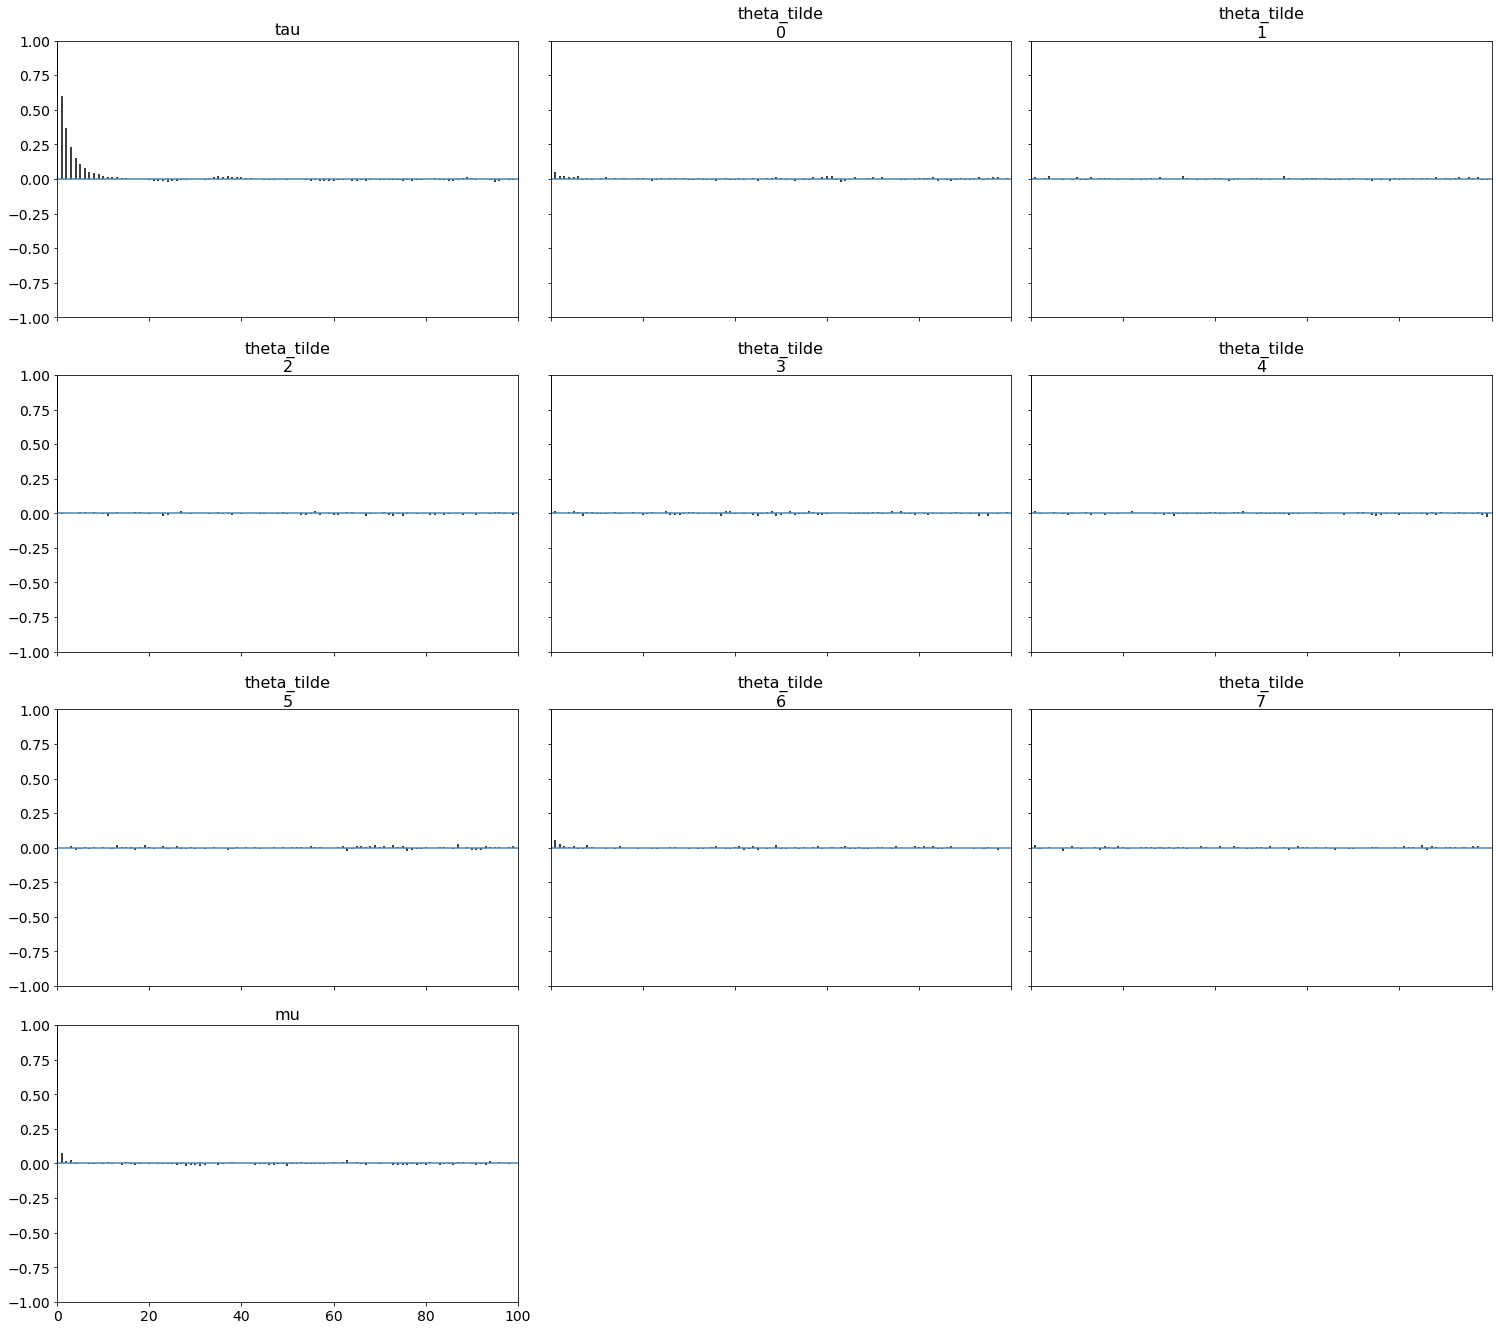

In [12]:
az.plot_autocorr(pyjags_data, combined=True);

## Compute effective sample size

In [13]:
az.ess(pyjags_data)

<xarray.Dataset>
Dimensions:            (theta_tilde_dim_0: 8)
Coordinates:
  * theta_tilde_dim_0  (theta_tilde_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    tau                float64 4.338e+03
    theta_tilde        (theta_tilde_dim_0) float64 1.203e+04 ... 1.551e+04
    mu                 float64 1.297e+04

## Generate Trace Plot

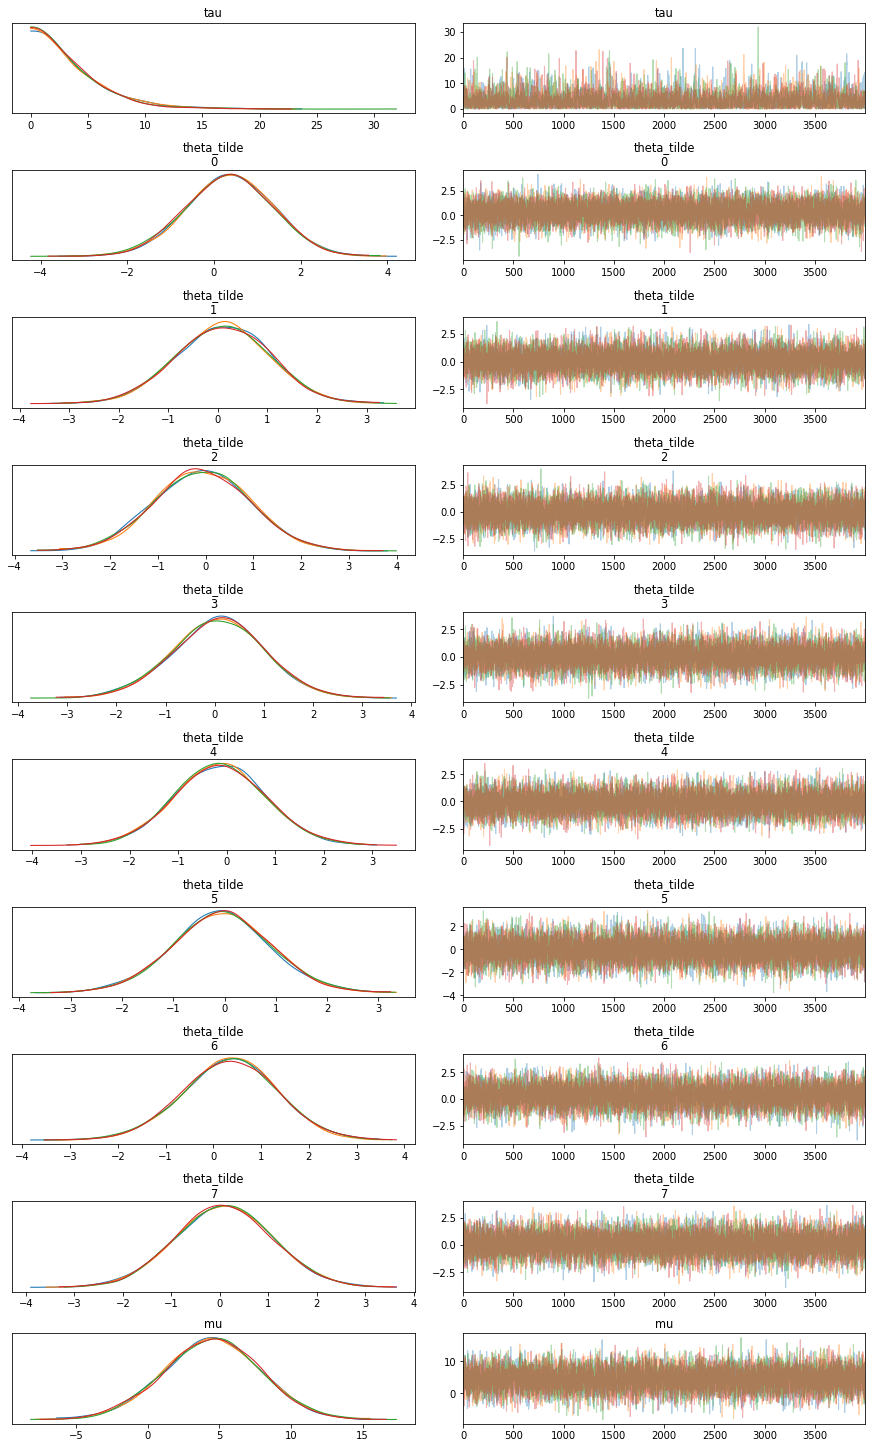

In [14]:
az.plot_trace(pyjags_data);

## Compute Summary Statistics

In [15]:
az.summary(pyjags_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,3.563,3.198,0.000,9.200,0.054,0.040,3573.0,3236.0,4338.0,4460.0,1.0
theta_tilde[0],0.341,0.986,-1.507,2.192,0.009,0.006,12048.0,12048.0,12035.0,15148.0,1.0
theta_tilde[1],0.089,0.938,-1.726,1.779,0.008,0.005,15188.0,15034.0,15174.0,15029.0,1.0
theta_tilde[2],-0.078,0.983,-1.918,1.762,0.008,0.006,15637.0,15637.0,15622.0,15026.0,1.0
theta_tilde[3],0.066,0.936,-1.714,1.839,0.008,0.005,15142.0,14612.0,15143.0,15529.0,1.0
theta_tilde[4],-0.143,0.935,-1.927,1.608,0.007,0.005,15550.0,14677.0,15559.0,15368.0,1.0
theta_tilde[5],-0.073,0.949,-1.890,1.717,0.008,0.005,15937.0,15901.0,15938.0,15187.0,1.0
theta_tilde[6],0.332,0.972,-1.451,2.211,0.009,0.006,13017.0,13017.0,13039.0,15222.0,1.0
theta_tilde[7],0.074,0.982,-1.725,1.944,0.008,0.006,15509.0,14552.0,15508.0,15847.0,1.0
mu,4.440,3.318,-1.818,10.635,0.029,0.021,12951.0,12951.0,12969.0,13804.0,1.0


## Generate Posterior Plot

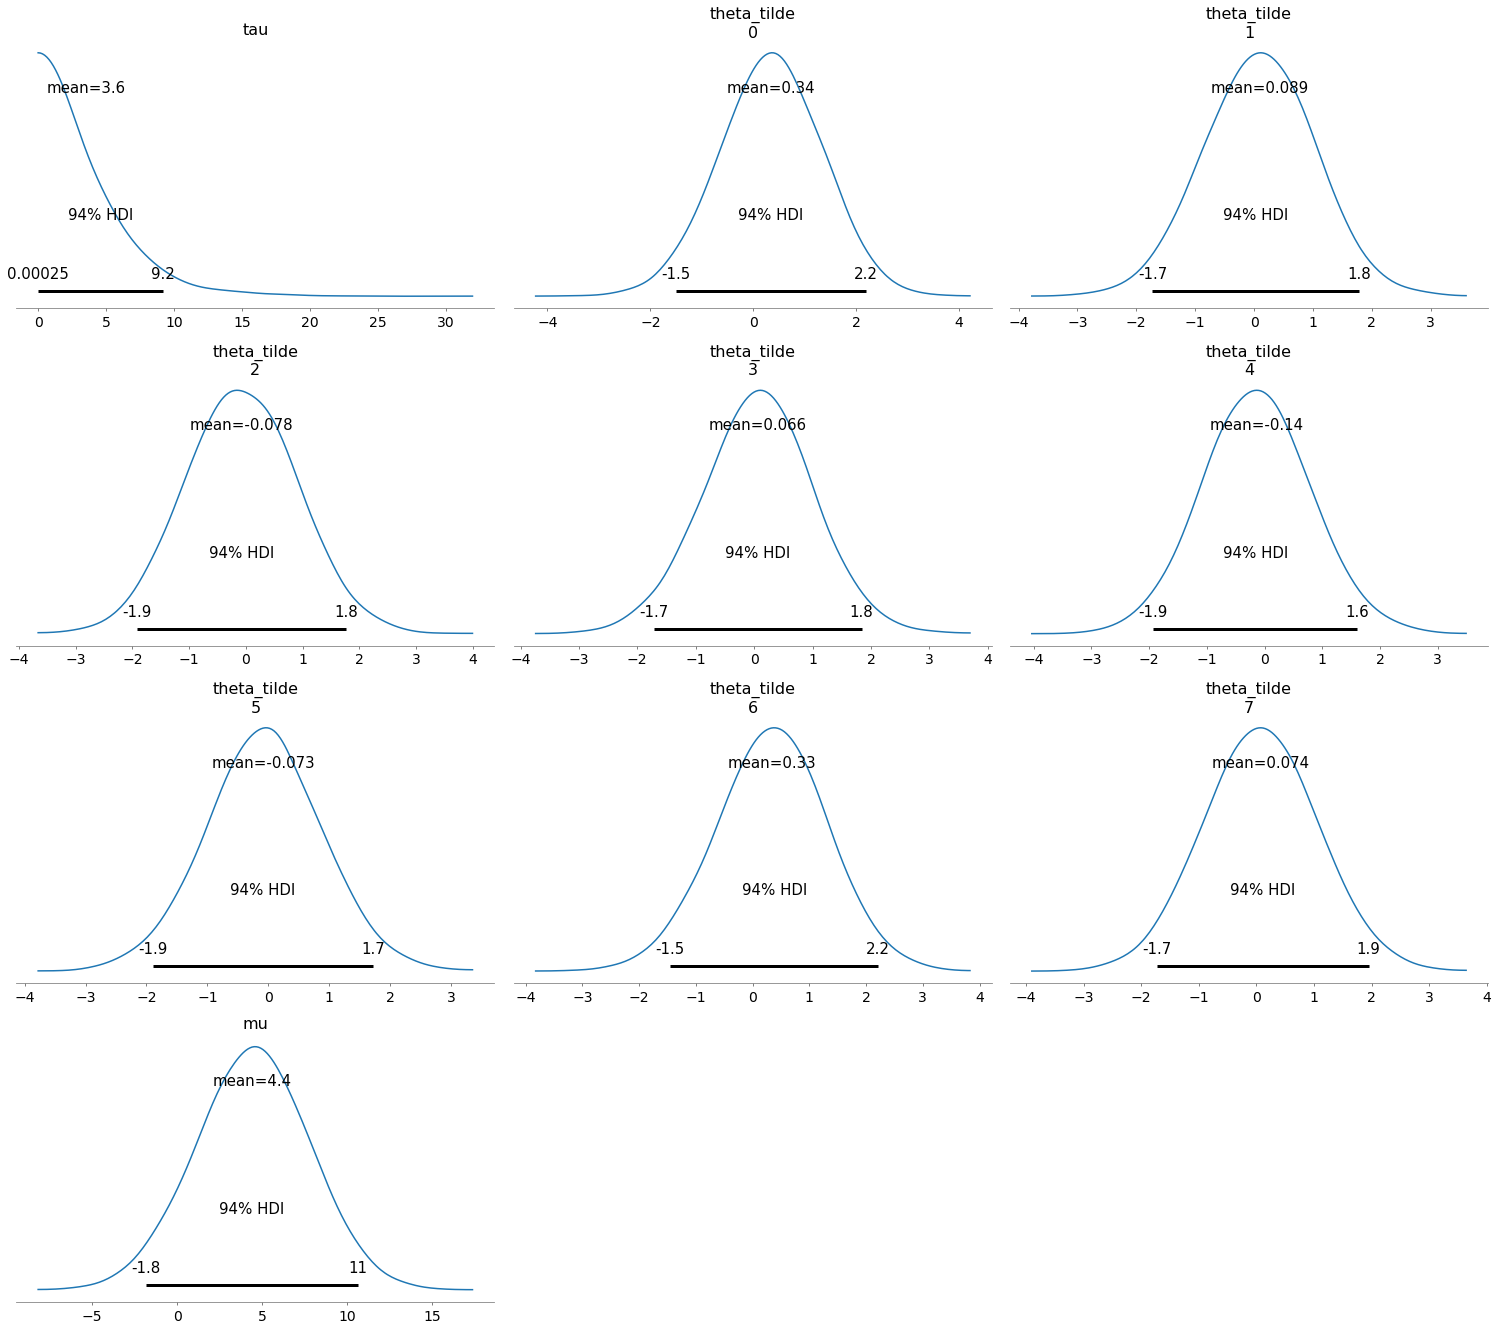

In [16]:
az.plot_posterior(pyjags_data);

Compute WAIC

In [17]:
az.waic(pyjags_data);

# Do Everything in PyMC3 for Comparison

## Import Packages and Set Simulation Parameters

In [18]:
import pymc3 as pm

draws = 5000
chains = 4

# eight_schools_data = {
#     "J": 8,
#     "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
#     "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
# }

## Construct PyMC3 Model and Generate Posterior Samples

In [19]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_tilde", mu=0, sd=1, shape=eight_schools_data["J"])
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    pm.Normal(
        "obs", mu=theta, sd=eight_schools_data["sigma"], observed=eight_schools_data["y"]
    )

    trace = pm.sample(draws, chains=chains)
    prior = pm.sample_prior_predictive()
#     posterior_predictive = pm.sample_posterior_predictive(trace)

    pymc3_data = az.from_pymc3(
        trace=trace,
        prior=prior,
#         posterior_predictive=posterior_predictive,
        coords={"school": np.arange(eight_schools_data["J"])},
        dims={"theta": ["school"], "theta_tilde": ["school"]},
    )
pymc3_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_tilde, tau, mu]
Sampling 4 chains, 9 divergences: 100%|██████████| 22000/22000 [00:05<00:00, 3710.94draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## Generate Trace Plot

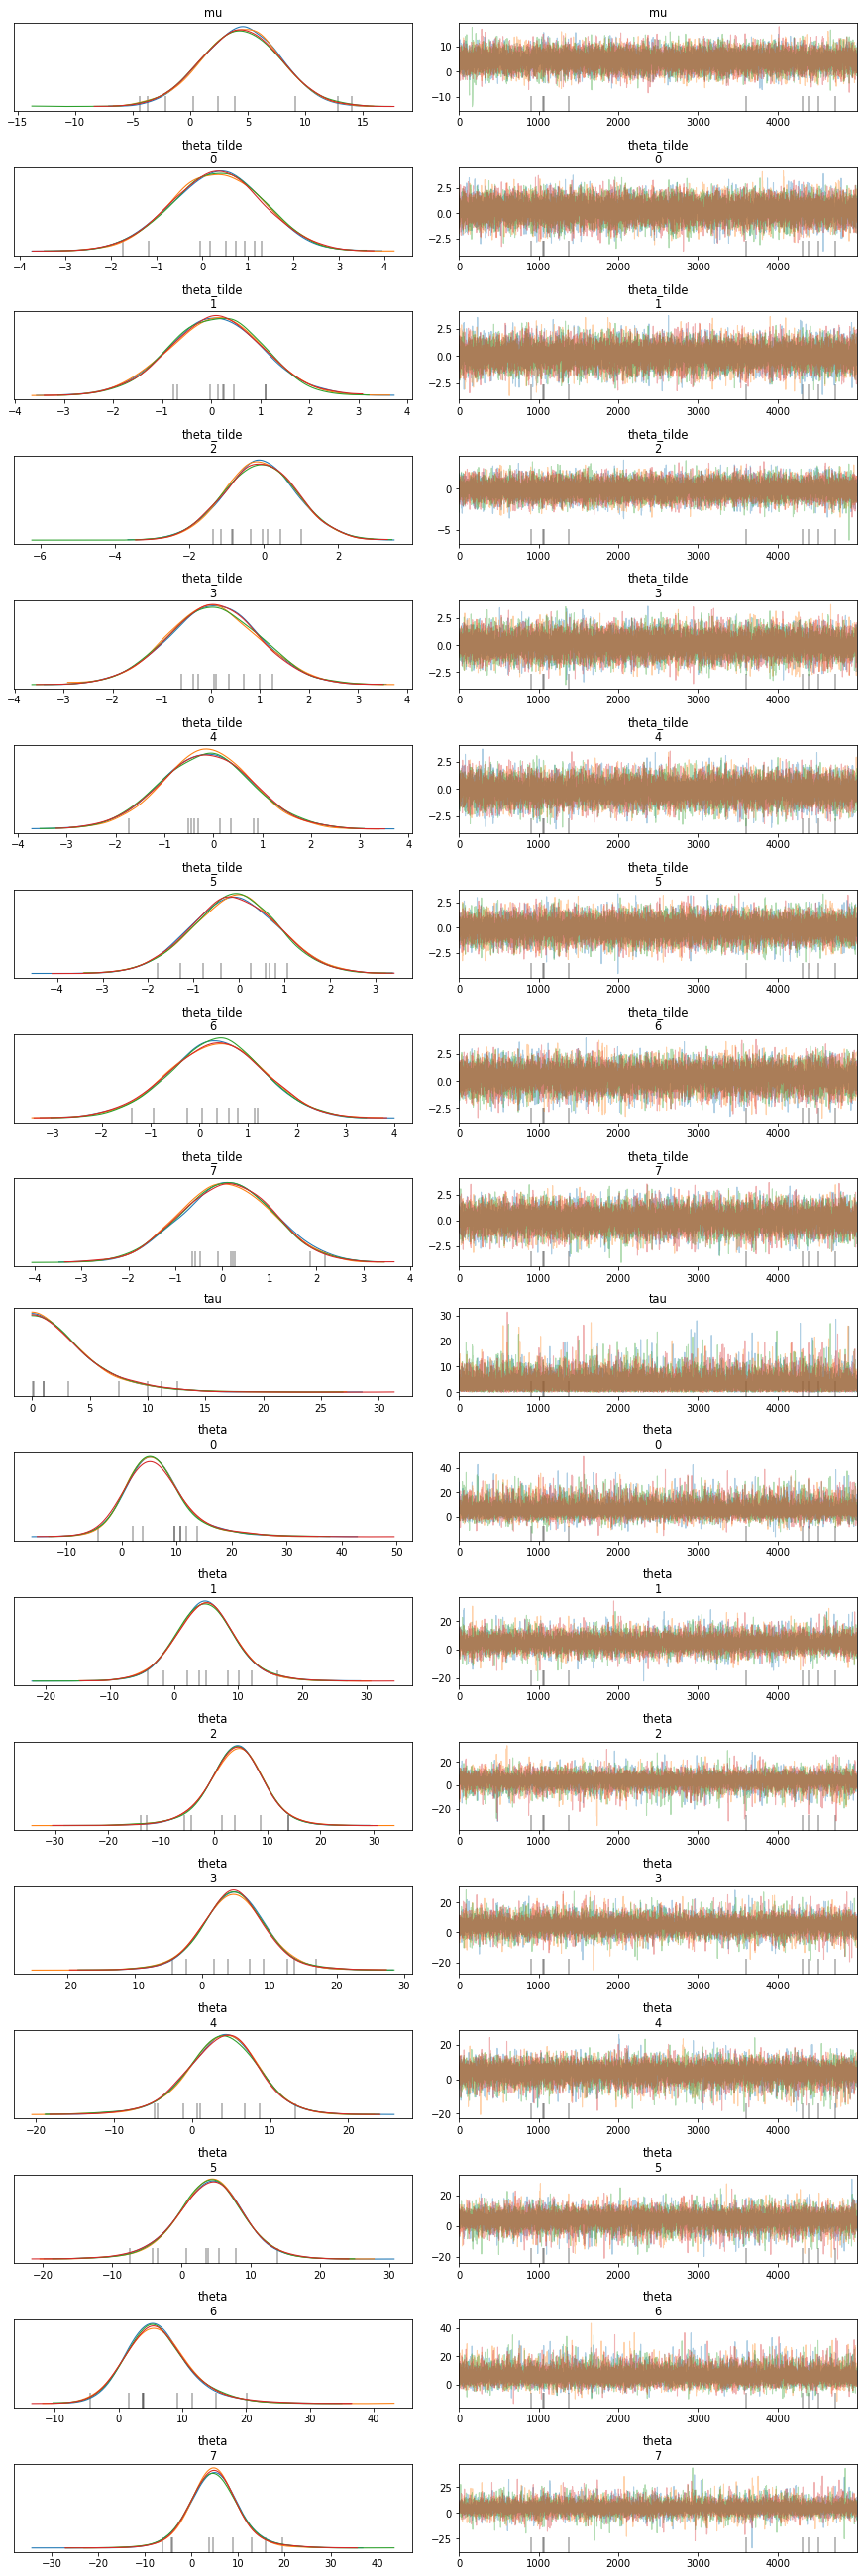

In [20]:
az.plot_trace(pymc3_data);

## Compute Summary Statistics

In [21]:
az.summary(pymc3_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.425,3.381,-1.981,10.624,0.024,0.019,19197.0,16534.0,20992.0,12826.0,1.0
theta_tilde[0],0.328,0.991,-1.544,2.173,0.006,0.007,27327.0,9627.0,27269.0,14817.0,1.0
theta_tilde[1],0.095,0.946,-1.709,1.845,0.006,0.007,25488.0,8159.0,25491.0,13961.0,1.0
theta_tilde[2],-0.088,0.967,-1.888,1.756,0.006,0.007,29255.0,8710.0,29250.0,13548.0,1.0
theta_tilde[3],0.061,0.935,-1.724,1.799,0.006,0.007,25397.0,8696.0,25387.0,14336.0,1.0
theta_tilde[4],-0.133,0.937,-1.940,1.610,0.006,0.007,25713.0,8690.0,25716.0,14306.0,1.0
theta_tilde[5],-0.087,0.950,-1.906,1.670,0.005,0.008,32641.0,7928.0,32653.0,14831.0,1.0
theta_tilde[6],0.341,0.968,-1.469,2.189,0.006,0.007,24329.0,9822.0,24292.0,14243.0,1.0
theta_tilde[7],0.096,0.977,-1.655,2.000,0.006,0.008,26203.0,8177.0,26166.0,14237.0,1.0
tau,3.636,3.275,0.001,9.444,0.030,0.024,11939.0,9477.0,11054.0,8274.0,1.0


In [22]:
az.summary(pyjags_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau,3.563,3.198,0.000,9.200,0.054,0.040,3573.0,3236.0,4338.0,4460.0,1.0
theta_tilde[0],0.341,0.986,-1.507,2.192,0.009,0.006,12048.0,12048.0,12035.0,15148.0,1.0
theta_tilde[1],0.089,0.938,-1.726,1.779,0.008,0.005,15188.0,15034.0,15174.0,15029.0,1.0
theta_tilde[2],-0.078,0.983,-1.918,1.762,0.008,0.006,15637.0,15637.0,15622.0,15026.0,1.0
theta_tilde[3],0.066,0.936,-1.714,1.839,0.008,0.005,15142.0,14612.0,15143.0,15529.0,1.0
theta_tilde[4],-0.143,0.935,-1.927,1.608,0.007,0.005,15550.0,14677.0,15559.0,15368.0,1.0
theta_tilde[5],-0.073,0.949,-1.890,1.717,0.008,0.005,15937.0,15901.0,15938.0,15187.0,1.0
theta_tilde[6],0.332,0.972,-1.451,2.211,0.009,0.006,13017.0,13017.0,13039.0,15222.0,1.0
theta_tilde[7],0.074,0.982,-1.725,1.944,0.008,0.006,15509.0,14552.0,15508.0,15847.0,1.0
mu,4.440,3.318,-1.818,10.635,0.029,0.021,12951.0,12951.0,12969.0,13804.0,1.0
